In [20]:
import numpy as np
import pandas as pd
import random
import mir_utils as miru
import sounddevice as sd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from ast import literal_eval

#copy of openset CNN at bottom
def fitSVM(encoding_path):
    
    testFraction=0.4
    #load same data as t-SNE but train SVM with it

    label_groups="label"
    label_groups="drum_type"

    df=pd.read_csv(encoding_path)
    df=df.loc[df["drum_type"].isin(["clap","hat","kick","snare","synth_noise"])]  
#     print(df.groupby([label_groups]).agg("count")["path"])#sample counts


    #preperocessing
    le = preprocessing.LabelEncoder()
    le.fit(df[label_groups])
    le.transform(df[label_groups])
    df[label_groups]=le.transform(df[label_groups])
    y_counts=df.groupby([label_groups]).agg("count")["path"] #for weights


    #calculating weights
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}


    y=df[label_groups]

    df["feats"]=df["feats"].apply(literal_eval)
    #df[feats] is an array of lists, needs conversion to ndArray
    X=np.array([np.array(x) for x in df["feats"].to_numpy()])
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}


    classifier = make_pipeline(StandardScaler(), SVC(gamma='auto',class_weight=class_weights))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testFraction, random_state=42,)

    classifier.fit(X_train, y_train,)
    y_pred = classifier.predict(X_test)


    return classifier, X_train, X_test, y_train, y_test,y_pred 

p1="csvs/radarfree_best_emb.csv"
p2="csvs/radarfree_best_embenv.csv"
classifier, X_train, X_test, y_train, y_test,y_pred  = fitSVM(p1)
print(confusion_matrix(y_test,y_pred))
print(classification_report(le.inverse_transform(y_test),le.inverse_transform(y_pred)))
classifier, X_train, X_test, y_train, y_test,y_pred  = fitSVM(p2)
print(confusion_matrix(y_test,y_pred))
print(classification_report(le.inverse_transform(y_test),le.inverse_transform(y_pred)))

[[123  13   1  10   8]
 [  9 455  13  25  13]
 [  1   0 509  28   3]
 [ 31  20  48 322   6]
 [  7   9   1   5 358]]
              precision    recall  f1-score   support

        clap       0.72      0.79      0.75       155
         hat       0.92      0.88      0.90       515
        kick       0.89      0.94      0.91       541
       snare       0.83      0.75      0.79       427
 synth_noise       0.92      0.94      0.93       380

    accuracy                           0.88      2018
   macro avg       0.85      0.86      0.86      2018
weighted avg       0.88      0.88      0.87      2018

[[123  16   1  10   5]
 [  8 464  13  22   8]
 [  1   0 508  29   3]
 [ 36  20  41 325   5]
 [  5   6   2   3 364]]
              precision    recall  f1-score   support

        clap       0.71      0.79      0.75       155
         hat       0.92      0.90      0.91       515
        kick       0.90      0.94      0.92       541
       snare       0.84      0.76      0.80       427
 synth_n

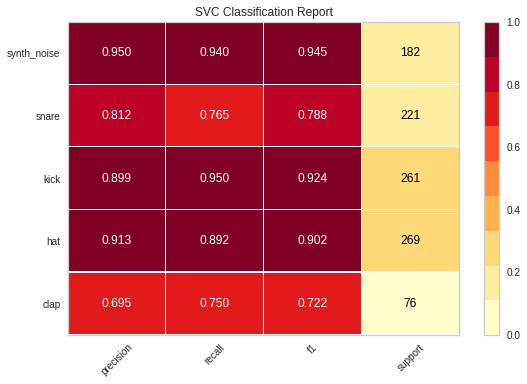

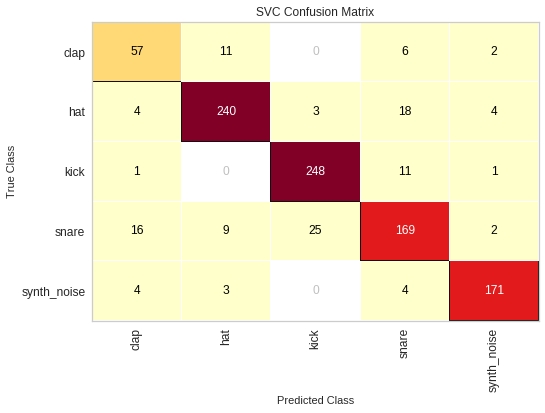

In [10]:
from yellowbrick.classifier import ClassificationReport,ConfusionMatrix

visualizer = ClassificationReport(classifier,classes=le.classes_, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(classifier, classes=le.classes_)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()